<a href="https://colab.research.google.com/github/Anku0210/NYC-Taxi-Trip-Time-Prediction/blob/main/Project_of_NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

Data preprocessing

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn import preprocessing
import math

In [53]:
#load NYC Taxi trip time dataset
data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/project/NYC Taxi Data.csv",sep=",")

In [54]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [56]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [57]:
data.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))) # to change scientific value to count value

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06
mean,1.53495,1.66453,-73.9735,40.7509,-73.9734,40.7518,959.492
std,0.498777,1.31424,0.0709019,0.0328812,0.0706433,0.0358906,5237.43
min,1,0,-121.933,34.3597,-121.933,32.1811,1
25%,1,1,-73.9919,40.7373,-73.9913,40.7359,397
50%,2,1,-73.9817,40.7541,-73.9798,40.7545,662
75%,2,2,-73.9673,40.7684,-73.963,40.7698,1075
max,2,9,-61.3355,51.8811,-61.3355,43.921,3.52628e+06


In [58]:
from geopy.distance import great_circle

In [59]:
def find_distance(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
 
 start=(pickup_lat,pickup_long)
 end=(dropoff_lat,dropoff_long)
 
 return great_circle(start,end).km

In [60]:
#finding distance travel in each trip
data['distance'] = data.apply(lambda x: find_distance(x['pickup_latitude'],
                                                      x['pickup_longitude'],
                                                      x['dropoff_latitude'],
                                                      x['dropoff_longitude'] ), axis=1)

feature creation

In [61]:
data['avg_speed'] = (data.distance/(data.trip_duration/3600))

In [62]:
data['pickup_weekday']=data['pickup_datetime'].dt.day_name()
data['dropoff_weekday']=data['dropoff_datetime'].dt.day_name()
data['pickup_weekday_num']=data['pickup_datetime'].dt.weekday
data['pickup_hour']=data['pickup_datetime'].dt.hour
data['month']=data['pickup_datetime'].dt.month

divided time zone into four main catogory

Morning (6AM to 12PM)
Afternoon (12 PM to 4 PM)
Evening (4PM to 10 PM)
Late night (10PM to 6AM)

In [63]:
# at which time customer board taxi 
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'

In [64]:
data['pickup_timeofday']=data['pickup_hour'].apply(time_of_day)

In [65]:
data.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,avg_speed,pickup_weekday_num,pickup_hour,month
count,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06
mean,1.53495,1.66453,-73.9735,40.7509,-73.9734,40.7518,959.492,3.44087,14.4232,3.05037,13.6065,3.51682
std,0.498777,1.31424,0.0709019,0.0328812,0.0706433,0.0358906,5237.43,4.29654,14.9775,1.95404,6.39969,1.68104
min,1,0,-121.933,34.3597,-121.933,32.1811,1,0,0,0,0,1
25%,1,1,-73.9919,40.7373,-73.9913,40.7359,397,1.23184,9.12129,1,9,2
50%,2,1,-73.9817,40.7541,-73.9798,40.7545,662,2.09372,12.792,3,14,4
75%,2,2,-73.9673,40.7684,-73.963,40.7698,1075,3.87534,17.8449,5,19,5
max,2,9,-61.3355,51.8811,-61.3355,43.921,3.52628e+06,1240.91,9274.85,6,23,6


In [66]:
data.shape

(1458644, 19)

In [67]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance', 'avg_speed', 'pickup_weekday',
       'dropoff_weekday', 'pickup_weekday_num', 'pickup_hour', 'month',
       'pickup_timeofday'],
      dtype='object')

In [68]:
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,avg_speed,pickup_weekday_num,pickup_hour,month
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,3.440869e+00,1.442323e+01,3.050375e+00,1.360648e+01,3.516818e+00
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,4.296544e+00,1.497755e+01,1.954039e+00,6.399693e+00,1.681038e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,1.231838e+00,9.121288e+00,1.000000e+00,9.000000e+00,2.000000e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,2.093720e+00,1.279200e+01,3.000000e+00,1.400000e+01,4.000000e+00
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,3.875343e+00,1.784494e+01,5.000000e+00,1.900000e+01,5.000000e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,1.240910e+03,9.274850e+03,6.000000e+00,2.300000e+01,6.000000e+00


##Univariate Analysis

In [69]:
plt.rcParams["figure.figsize"] = [10,6]

In [70]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,avg_speed,pickup_weekday,dropoff_weekday,pickup_weekday_num,pickup_hour,month,pickup_timeofday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498523,11.856445,Monday,Monday,0,17,3,Evening
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805510,9.803673,Sunday,Sunday,6,0,6,Late night
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385108,10.822216,Tuesday,Tuesday,1,11,1,Morning
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485501,12.465739,Wednesday,Wednesday,2,19,4,Evening
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188590,9.836608,Saturday,Saturday,5,13,3,Afternoon


###**Column 1 and 2:** 'Column id' and 'Vendor_id'

There are only two vendor who provided service

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


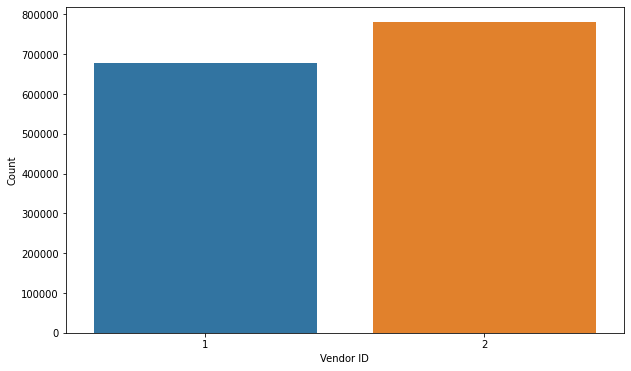

In [71]:
sns.countplot(data.vendor_id)
plt.xlabel('Vendor ID')
plt.ylabel('Count')
plt.show()

###**Column 3 and 4:** From'pickup_datetime' and 'dropoff_datetime' column we created new feature column like '**pickup_weekday**', '**dropoff_weekday**' '**pickup_weekday_num**', '**pickup_hour month**', and '**pickup_timeofday**'.

###**Column 5:** Passenger_count

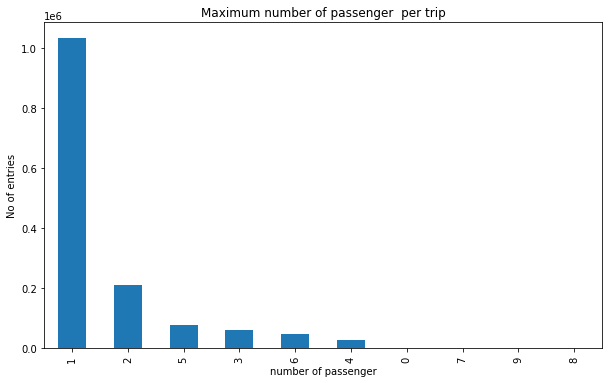

In [72]:
data.passenger_count.value_counts().plot(kind="bar")
plt.xlabel("number of passenger")
plt.ylabel("No of entries")
plt.title("Maximum number of passenger  per trip")
plt.show()


From the graph, we can see that there are few trips with passenger broad a taxi is too low. it may be outliers so going to reomve entries with 0, 7, 8, 9 passenger per trip.

###**Column 6:** Pickup_latitude pickup_longitude

In [73]:
import folium
from folium.plugins import HeatMap
from folium import plugins


In [74]:
map_NYC = folium.Map([60,-120],zoom_start=7)

In [75]:
'''station = data[['pickup_longitude','pickup_latitude']]
# convert to (n, 2) nd-array format for heatmap
stationArr = station.values

# plot heatmap
map_NYC.add_child(plugins.HeatMap(stationArr, radius=15))
map_NYC''''''station = data[['pickup_longitude','pickup_latitude']]
# convert to (n, 2) nd-array format for heatmap
stationArr = station.values

# plot heatmap
map_NYC.add_child(plugins.HeatMap(stationArr, radius=15))
map_NYC'''

"station = data[['pickup_longitude','pickup_latitude']]\n# convert to (n, 2) nd-array format for heatmap\nstationArr = station.values\n\n# plot heatmap\nmap_NYC.add_child(plugins.HeatMap(stationArr, radius=15))\nmap_NYCstation = data[['pickup_longitude','pickup_latitude']]\n# convert to (n, 2) nd-array format for heatmap\nstationArr = station.values\n\n# plot heatmap\nmap_NYC.add_child(plugins.HeatMap(stationArr, radius=15))\nmap_NYC"

###**Column 8 and 9:** Dropoff_latitude dropoff_longitude

In [76]:
map_NYC = folium.Map([40.80902,-73.94190],zoom_start=7)

In [77]:
'''station_drop = data[['dropoff_latitude', 'dropoff_longitude']]
# convert to (n, 2) nd-array format for heatmap
stationArr_drop = station_drop.values

# plot heatmap
map_NYC.add_child(plugins.HeatMap(stationArr_drop, radius=15))
map_NYC'''

"station_drop = data[['dropoff_latitude', 'dropoff_longitude']]\n# convert to (n, 2) nd-array format for heatmap\nstationArr_drop = station_drop.values\n\n# plot heatmap\nmap_NYC.add_child(plugins.HeatMap(stationArr_drop, radius=15))\nmap_NYC"

###**Column 10:** Store and forward flag

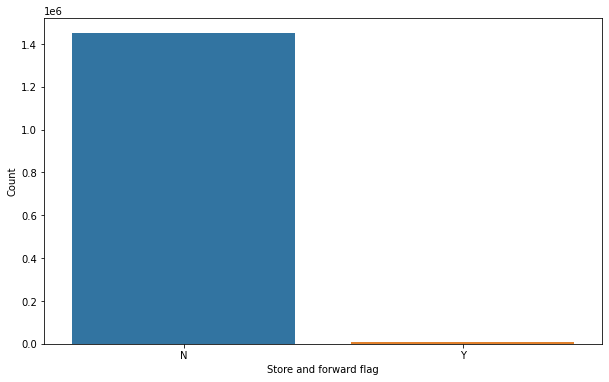

In [78]:
sns.countplot(x='store_and_fwd_flag',data=data)
plt.ylabel('Count')
plt.xlabel('Store and forward flag')
plt.show()

We can see that only about 0.5% of the trip details were stored in the vehicle memory first

###**Column 11:** Trip duration

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


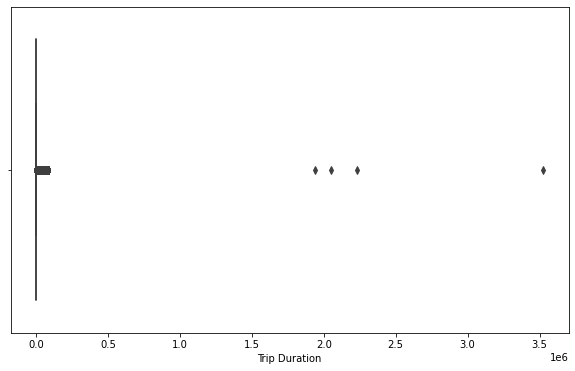

In [79]:
#create boxplot to check probable outliers
sns.boxplot(data.trip_duration)
plt.xlabel('Trip Duration')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


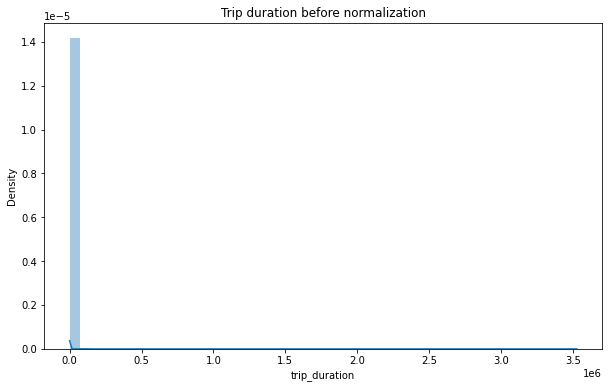

In [80]:
#to check skewness of data 
sns.distplot(data['trip_duration'],norm_hist=True)
plt.title("Trip duration before normalization")
plt.show()

In [81]:
print(f" skew coefficient is {data['trip_duration'].skew()}")

 skew coefficient is 343.1639435917362


Data is right skewed. using log transformation we can remove skewness.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


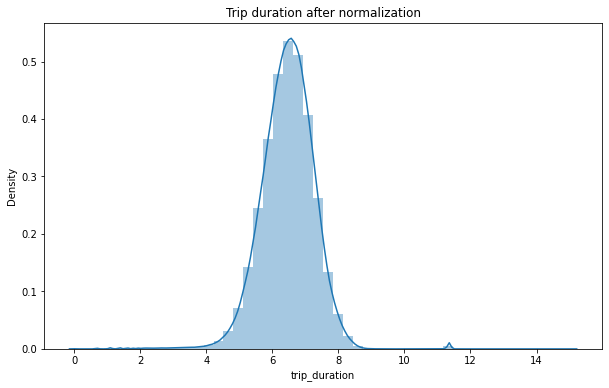

In [82]:
sns.distplot(np.log(data['trip_duration']))
plt.title("Trip duration after normalization")
plt.show()

In [83]:
np.log(data['trip_duration'])
data_trip_duration = np.log(data['trip_duration'])
print(f" skew coefficient went from {data['trip_duration'].skew()} to {data_trip_duration.skew()}")

 skew coefficient went from 343.1639435917362 to -0.34070423044801745


###**Column 12:** Distance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


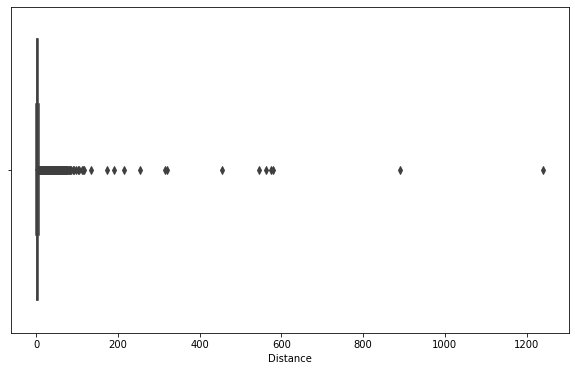

In [84]:
sns.boxplot(data.distance)
plt.xlabel('Distance')
plt.show()

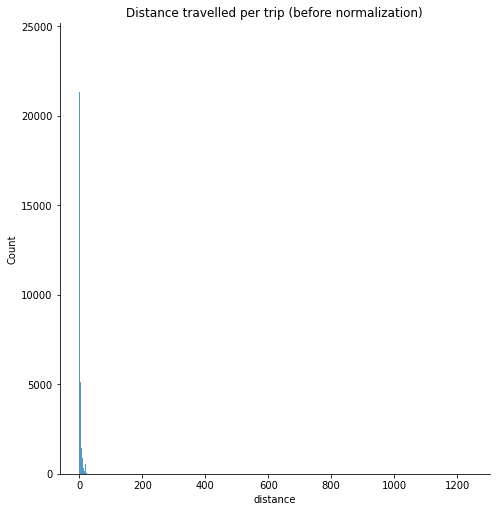

In [85]:
sns.displot(data=data, x='distance', height=7,aspect=1)
plt.title("Distance travelled per trip (before normalization)")
plt.show()

In [86]:
print(f"Skew coefficient is {data['distance'].skew()}")

Skew coefficient is 32.63098100465969


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


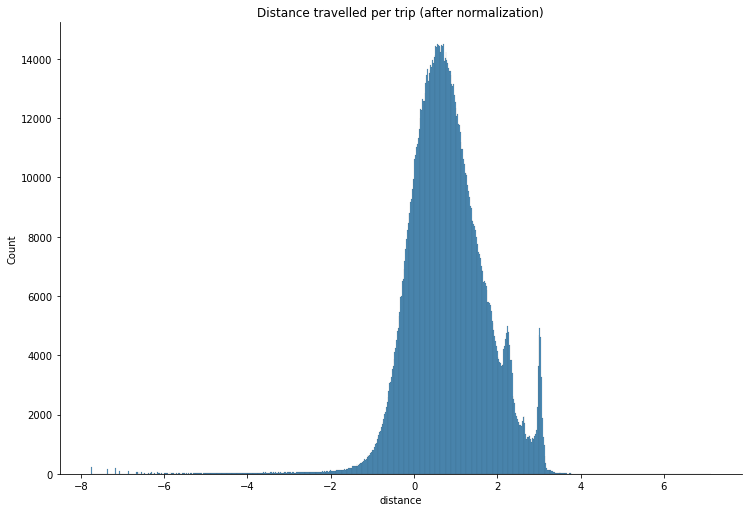

In [87]:
sns.displot(np.log(data["distance"]), height=7,aspect=1.5)
plt.title("Distance travelled per trip (after normalization)")
plt.show()

In [88]:
distance_log_skew = np.log(data['distance']).skew()
print(f" Skew coefficient went from {data['distance'].skew()} to {distance_log_skew}")

 Skew coefficient went from 32.63098100465969 to nan


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


###**Column 13:** Average speed

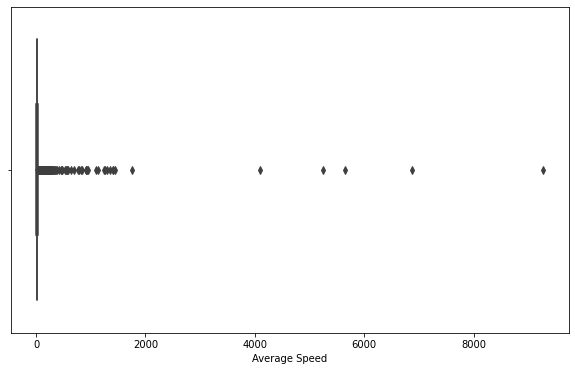

In [89]:
sns.boxplot(x="avg_speed", data=data)
plt.xlabel('Average Speed')
plt.show()

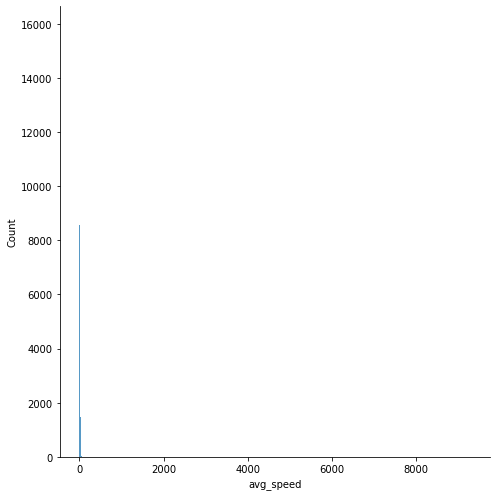

In [90]:
sns.displot(data=data, x='avg_speed', height=7,aspect=1)
plt.show()

In [91]:
print(f"Skew coefficient is {data['avg_speed'].skew()}")

Skew coefficient is 314.15810855999814


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


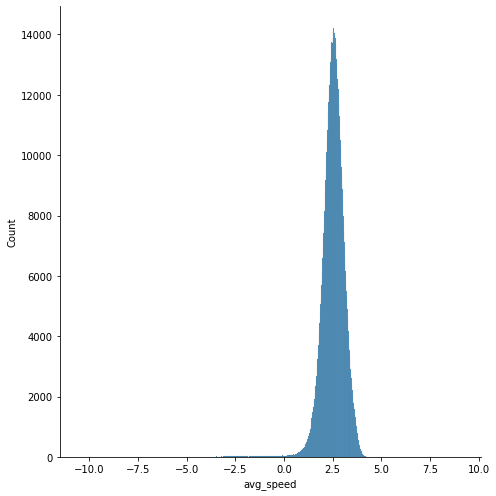

In [92]:
sns.displot(np.log(data["avg_speed"]), height=7,aspect=1)
plt.show()

In [93]:
speed_log_skew = np.log(data["avg_speed"]).skew()
print(f" Skew coefficient went from {data['avg_speed'].skew()} to {speed_log_skew}")

 Skew coefficient went from 314.15810855999814 to nan


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


###**Column 14 and 15:** Pickup_weekday and drop off weekday

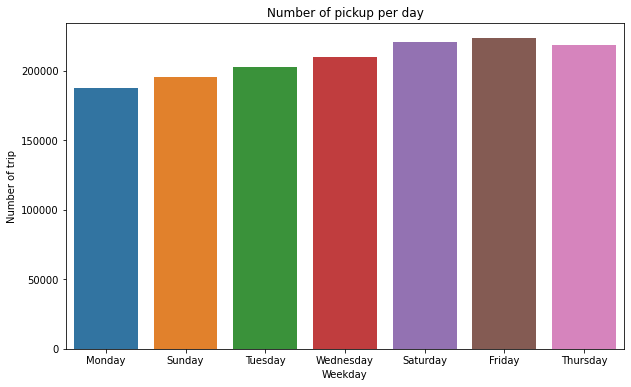

In [94]:
sns.countplot(data=data, x='pickup_weekday')
plt.ylabel('Number of trip')
plt.xlabel('Weekday')
plt.title('Number of pickup per day')
plt.show()

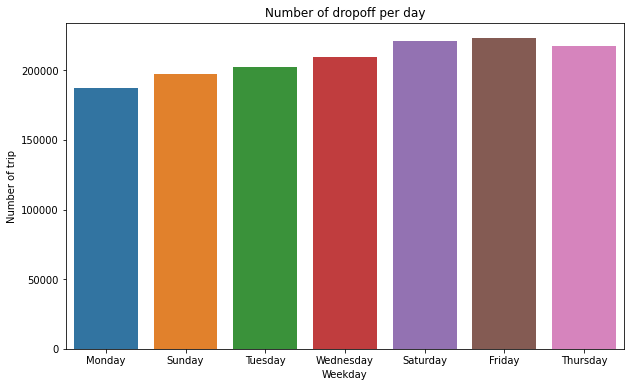

In [95]:
sns.countplot(data=data, x='dropoff_weekday')
plt.ylabel('Number of trip')
plt.xlabel('Weekday')
plt.title('Number of dropoff per day')
plt.show()

###**Column 16:** Pick up hour

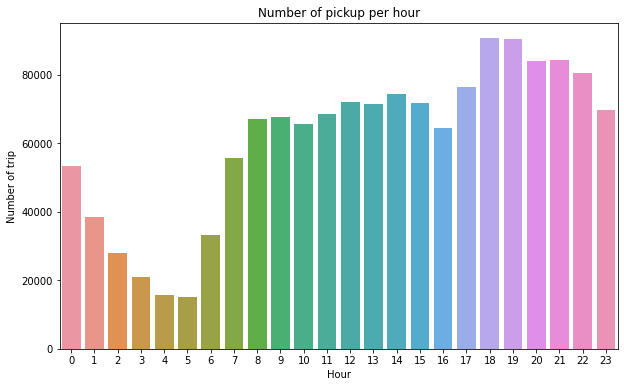

In [96]:
sns.countplot(data=data, x='pickup_hour')
plt.ylabel('Number of trip')
plt.xlabel('Hour')
plt.title('Number of pickup per hour')
plt.show()

###**Column 17:** Month

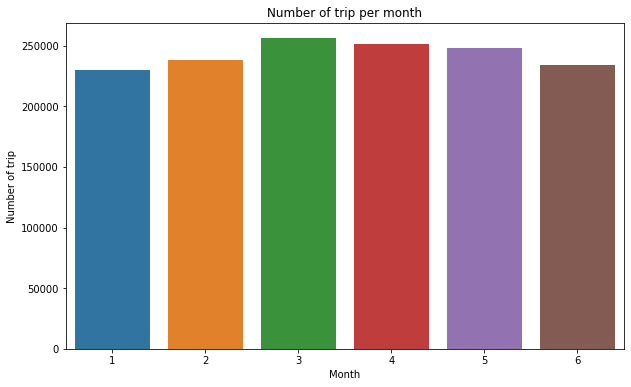

In [97]:
sns.countplot(data=data, x='month')
plt.ylabel('Number of trip')
plt.xlabel('Month')
plt.title('Number of trip per month')
plt.show()

In [98]:
data.month.value_counts()

3    256189
4    251645
5    248487
2    238300
6    234316
1    229707
Name: month, dtype: int64

###**Column 18:** Pick up time of day

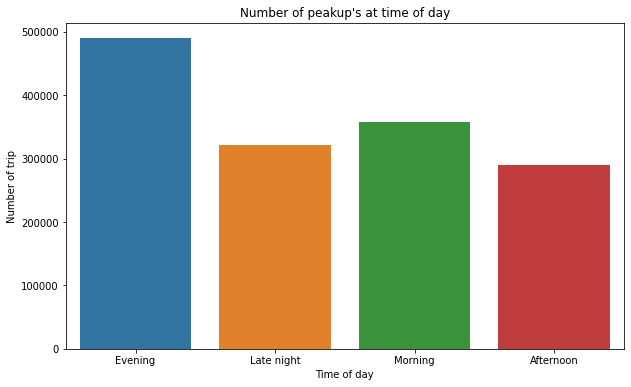

In [99]:
# bar plot for pickup time of a day
sns.countplot(data=data, x="pickup_timeofday")
plt.xlabel("Time of day")
plt.ylabel("Number of trip")
plt.title("Number of peakup's at time of day")
plt.show()

##Bivariate Analysis

###Trip Duration Vs Vendor

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


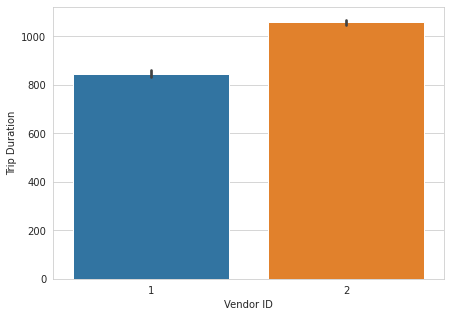

In [100]:
sns.set_style(style='whitegrid')
plt.figure(figsize = (7,5))
sns.barplot(data.vendor_id,data.trip_duration)
plt.xlabel('Vendor ID')
plt.ylabel('Trip Duration')
plt.show()

###Trip Duration Vs Store and Forward Flag

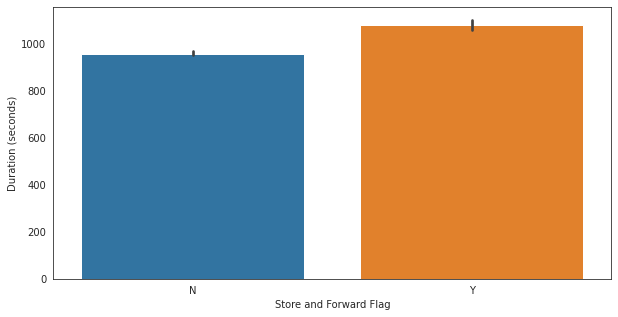

In [101]:
plt.figure(figsize = (10,5))
sns.set_style(style='white')
sns.barplot(x=data.store_and_fwd_flag, y=data.trip_duration)
plt.xlabel('Store and Forward Flag')
plt.ylabel('Duration (seconds)')
plt.show()

Y type Store and Forward Flag are relatively taking longer trip 
duration.

Also we found that from univariate analysis only 1% data is having Y type Store and Forward Flag

###Trip Duration Vs Pickup Time

Text(0.5, 1.0, 'Line Plot')

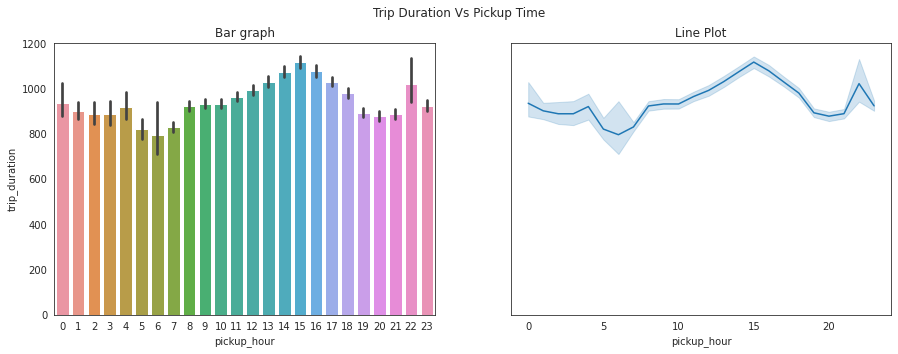

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Trip Duration Vs Pickup Time')

sns.barplot(ax=axes[0], x='pickup_hour',y='trip_duration',data=data)
axes[0].set_title('Bar graph')

sns.lineplot(ax=axes[1], x='pickup_hour',y='trip_duration',data=data)
axes[1].set_title('Line Plot')

We see the trip duration is the maximum around 1 pm to 4 pm.

Trip duration is the lowest in morning aroud 6 am

###Trip Duration Vs Weekday

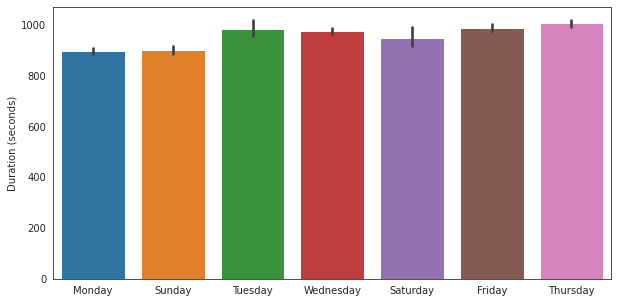

In [103]:
plt.figure(figsize = (10,5))
sns.barplot(x='pickup_weekday',y='trip_duration',data=data)
plt.ylabel('Duration (seconds)')
plt.xlabel('')
plt.show()

Trip duration on Wednesday is longest among all days.

###Trip Duration Vs Month

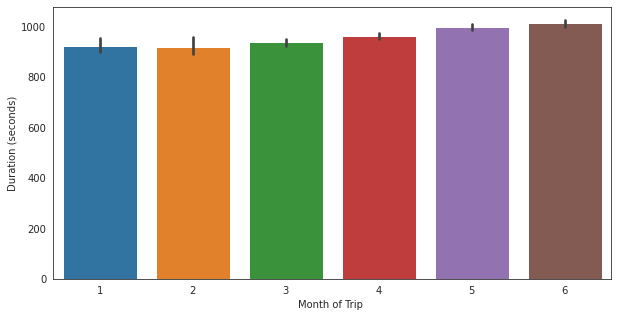

In [104]:
plt.figure(figsize = (10,5))
sns.barplot(x='month',y='trip_duration', data=data)
plt.ylabel('Duration (seconds)')
plt.xlabel('Month of Trip ')
plt.show()

Trip duration gradually increasing from Jan to June

###Trip Duration Vs Distance

Text(0.5, 1.0, 'Scatter plot')

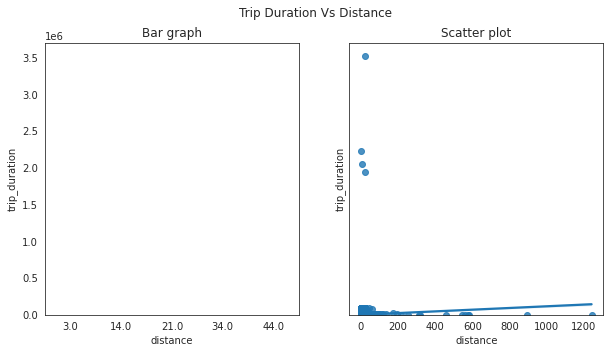

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig.suptitle('Trip Duration Vs Distance')

sns.barplot(ax=axes[0], x=data.distance.groupby(pd.cut(data.distance,np.arange(0,60,10))).mean().round(),y='trip_duration'
                                                       ,data=data,ci=None)
axes[0].set_title('Bar graph')

sns.regplot(ax=axes[1],
            x='distance',
            y='trip_duration',
            data=data)
axes[1].set_title('Scatter plot')


As the distance increases the trip time also increasing

###Distance Vs Hour

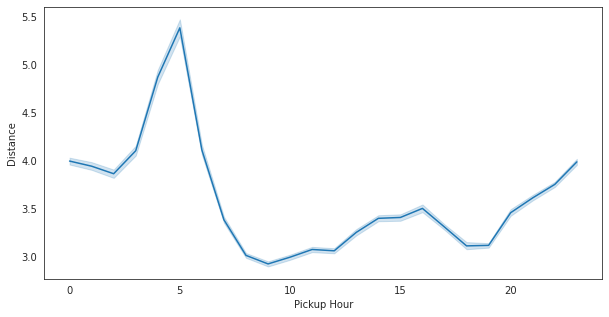

In [106]:
plt.figure(figsize = (10,5))
sns.lineplot(y='distance',x='pickup_hour',data=data)
plt.ylabel('Distance')
plt.xlabel('Pickup Hour')
plt.show()

Trip distance is highest during early morning hours.

From 8 am to night 8 pm distance people are riding short distance trips in the range of 3 - 4 kms.

###Distance vs Weekday

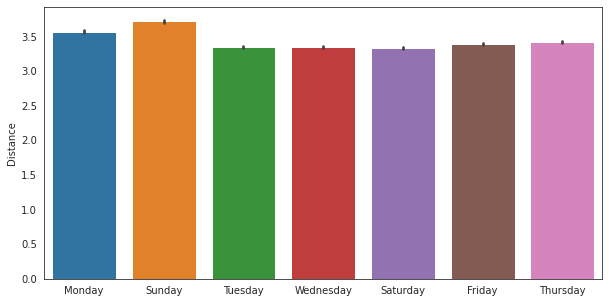

In [107]:
plt.figure(figsize = (10,5))
sns.barplot(x='pickup_weekday', y='distance',data=data)
plt.ylabel('Distance')
plt.xlabel('')
plt.show()

Sunday being at the top may be due to outstation trips

###Distance Vs Month

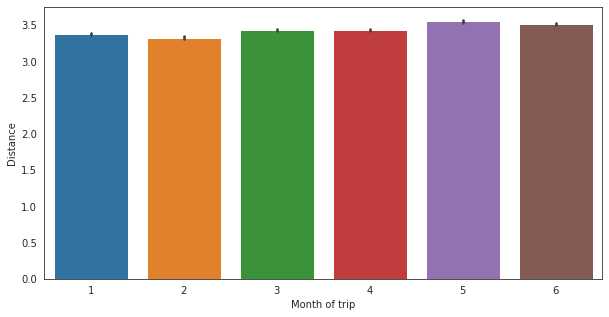

In [108]:
plt.figure(figsize = (10,5))
sns.barplot(x='month', y='distance',data=data)
plt.ylabel('Distance')
plt.xlabel('Month of trip')
plt.show()

There is not much differece in distance travelled in each month

In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 19 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  distance            1458644 non-null  float64       
 12  avg_speed           1458644 non-null  float64       
 13  pickup_weekd

##Feature Engineering

###Data cleaing and wrangling

In [110]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,avg_speed,pickup_weekday,dropoff_weekday,pickup_weekday_num,pickup_hour,month,pickup_timeofday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498523,11.856445,Monday,Monday,0,17,3,Evening
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805510,9.803673,Sunday,Sunday,6,0,6,Late night
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385108,10.822216,Tuesday,Tuesday,1,11,1,Morning
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485501,12.465739,Wednesday,Wednesday,2,19,4,Evening
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188590,9.836608,Saturday,Saturday,5,13,3,Afternoon


In [111]:
# remove column  "id" and "vendor_id"
data.drop(["id",'pickup_datetime',"dropoff_datetime", "dropoff_longitude", "dropoff_latitude", "pickup_longitude", "pickup_latitude","pickup_hour"],axis=1,inplace= True)

In [112]:
data.shape

(1458644, 11)

In [113]:
#remove rows with passenger count value =0,7,8,9
df = data.loc[~(data['passenger_count']==0)]
df = df.loc[~(df['passenger_count'] >= 7)]

In [114]:
df.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

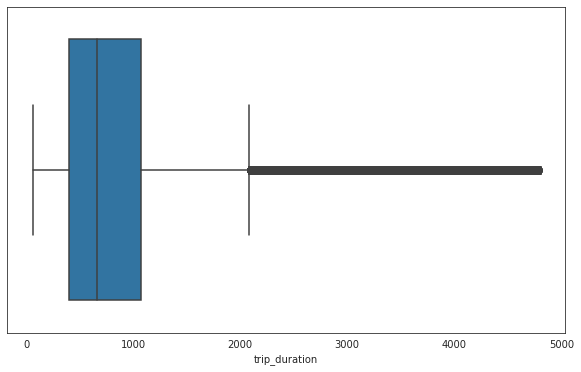

In [115]:
#remove trip duration greater than 5800 second and less han 60 sec.
df = df.loc[~(df['trip_duration'] >= 4800)]
df = df.loc[~(df['trip_duration'] <= 60)]
#plot boxplot for filtered data
sns.boxplot(data=df,x='trip_duration')
plt.show()

In [116]:
df.shape

(1445584, 11)

Since we removed the data having greater than 80 min(4800sec) so we can remove the distance travelled > 100 km, and we seen that 99 percentile of the distance travelled is about 24 km

In [117]:
#remove distance above 200 and avg_speed above 50 km/hr (As 2015, maximum speed limit was 48.28 kmph)
df = df.loc[~((df['distance']>=100) | (df["avg_speed"]>=50))]

In [118]:
df.shape

(1442988, 11)

In [119]:
# remove rows if distance travel is zless less tham or equal to 1 (may be it outliers)
df = df[df.distance >= 1]

In [120]:
df.shape

(1206192, 11)

##Correlation

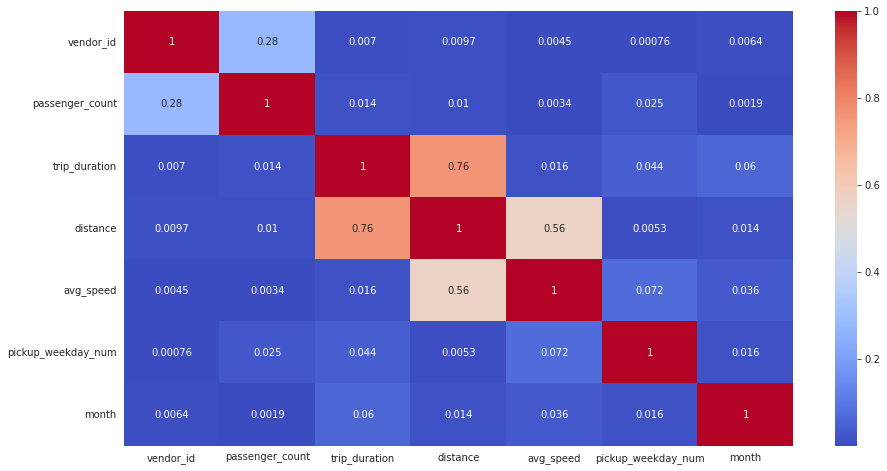

In [121]:
 ## Correlation
plt.figure(figsize=(15,8))
correlation = df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')
plt.show()

As we can see that,
"Avg_speed" is 56% corealted with distance.
"trip_duration" is 78% corealted with distance.

In [122]:
#we can also remove "pickup_weekday_num" as "pickup_weekday" and "dropoff_weekday" information also avalibale
df.drop(['pickup_weekday_num'],axis=1,inplace=True)

##Check multi collinearity

In [123]:
#Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
#define function to call multicollinearity
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [124]:
df.columns

Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'trip_duration',
       'distance', 'avg_speed', 'pickup_weekday', 'dropoff_weekday', 'month',
       'pickup_timeofday'],
      dtype='object')

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206192 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1206192 non-null  int64  
 1   passenger_count     1206192 non-null  int64  
 2   store_and_fwd_flag  1206192 non-null  object 
 3   trip_duration       1206192 non-null  int64  
 4   distance            1206192 non-null  float64
 5   avg_speed           1206192 non-null  float64
 6   pickup_weekday      1206192 non-null  object 
 7   dropoff_weekday     1206192 non-null  object 
 8   month               1206192 non-null  int64  
 9   pickup_timeofday    1206192 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 101.2+ MB


In [126]:
calc_vif(df[[i for i in df.describe().columns if i not in ["vendor_id",'passenger_count','store_and_fwd_flag', 'dropoff_weekday', 'pickup_weekday','month','pickup_timeofday']]])

,variables,VIF
0,trip_duration,4.703395
1,distance,6.048477
2,avg_speed,2.916573


we have also remove the Avg_speed feature from the predictor columns as it highhly corelated with distance.

In [127]:
calc_vif(df[[i for i in df.describe().columns if i not in ['passenger_count','store_and_fwd_flag', 'dropoff_weekday', 'pickup_weekday','month','pickup_timeofday','avg_speed','vendor_id']]])

,variables,VIF
0,trip_duration,4.652889
1,distance,4.652889


##One Hot Encoding

In [128]:
df.columns

Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'trip_duration',
       'distance', 'avg_speed', 'pickup_weekday', 'dropoff_weekday', 'month',
       'pickup_timeofday'],
      dtype='object')

In [129]:
# One hot encoding
final_data = pd.get_dummies(df, columns=["vendor_id",
                                         "passenger_count",
                                         "store_and_fwd_flag",
                                         "pickup_weekday",
                                         "dropoff_weekday",
                                         "month",
                                         "pickup_timeofday"])

In [130]:
final_data.head()

,trip_duration,distance,avg_speed,vendor_id_1,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,...,month_1,month_2,month_3,month_4,month_5,month_6,pickup_timeofday_Afternoon,pickup_timeofday_Evening,pickup_timeofday_Late night,pickup_timeofday_Morning
0,455,1.498523,11.856445,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,663,1.805510,9.803673,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,2124,6.385108,10.822216,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,429,1.485501,12.465739,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,435,1.188590,9.836608,0,1,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [131]:
final_data.shape

(1206192, 37)

Now we see corelation heatmap between each feature to choose best feature

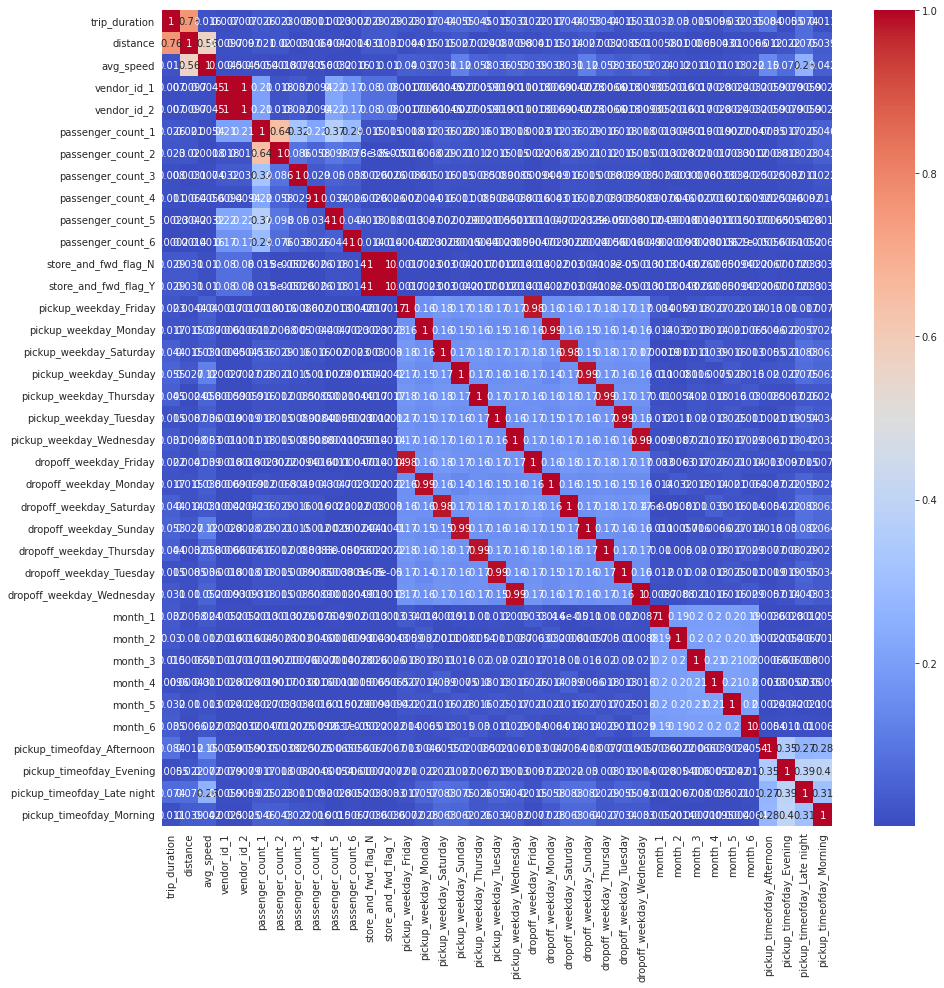

In [132]:
 ## Correlation
plt.figure(figsize=(15,15))
correlation_1 = final_data.corr()
sns.heatmap(abs(correlation_1), annot=True, cmap='coolwarm')
plt.show()